In [1]:
import skimage, os
from skimage.measure import label,regionprops, perimeter
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data, img_as_float
from skimage.transform import resize
from skimage import morphology
from skimage import measure
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import DBSCAN as Dbscan
from cv2 import erode
import math

In [3]:
def find_contour(imgg, point):

  imgg = cv2.medianBlur(imgg, 7)
  feature_array = np.empty((512,512,3))

  for x in range(512):
      for y in range(512):
          feature_array[x][y] = (x, y, (imgg[x][y] - 1000) * 5 if 1000 < imgg[x][y] < 1100 else 0)


  db = Dbscan(eps = 15, min_samples=15)
  predicted = db.fit_predict(feature_array.flatten().reshape(-1, 3)).reshape(512,512)


  img = predicted.astype('uint8')
  kernel = np.ones((2,2),dtype=np.uint8) # this must be tuned 
  img=erode(img,kernel)
  img = cv2.medianBlur(img, 5)


  contour_image = np.zeros(shape=[512, 512], dtype=np.uint8)
  contours,hierarchy = cv2.findContours(img,cv2.RETR_TREE,1)
  cir = 0

  for c in contours:
      
      perimeter = cv2.arcLength(c, True)
      area = cv2.contourArea(c)

      # GET center of contours
      M = cv2.moments(c)  
      
      try:
          cX = int(M["m10"] / M["m00"])
          cY = int(M["m01"] / M["m00"])
          
      except ZeroDivisionError:
          cX = int(M["m10"])
          cY = int(M["m01"])
      
      
      if perimeter == 0 or (area > 2000 or area < 500) or (cX < 220 or cX > 320) or (cY < 250 or cY > 300):
          continue
          
      else:
          
          print('center', cX, cY)
          
          (x,y),radius = cv2.minEnclosingCircle(c)
          center = (int(x),int(y))
          radius = int(radius)
          circularity = 4*math.pi*(area/(perimeter*perimeter))

          if 0.2 < circularity < 1.2:
              cir +=1
              cv2.drawContours(imgg, [c], -1, (255, 255, 0), 3)
              cv2.drawContours(contour_image, [c], -1, (255, 255, 255), 3)

          # print("<> Total circles " +  str(cir) + "\n\n")
          print("\nPerimeter: " + str(perimeter))
          print("Area: " + str(area))
          print("Diameter: " + str(radius*2))

  fig, axes = plt.subplots(1, 2, figsize=(8, 8))
  ax = axes.flatten()
  ax[0].imshow(imgg, cmap='gray')
  ax[1].imshow(contour_image, cmap='gray')

  return contour_image

In [10]:
import imageio
from pathlib import Path

def get_picture(pic):
    picture = imageio.imread(Path("unmarked") / pic)
    return picture

def get_center(pic):
    x, y = Path("marks", "centers", str(pic)+".center").open().read().split(", ")
    x, y = int(x), int(y)
    return (x, y)

def get_mask(pic):
    f = Path("marks", "masks", str(pic)+".binary")
    return imageio.imread(f).astype("bool")

In [8]:
dataset = [Path(*f.parts[-2:]) for f in Path("unmarked").glob("**/*.png") if f.parts[-2] != "02"]

In [12]:
from sklearn.metrics import jaccard_score

for pic in dataset:
    picture = get_picture(pic)
    truth = get_mask(pic)
    label = find_contour(picture).astype("bool")
    print(jaccard_score(label, truth))

ValueError: Target is multilabel-indicator but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted', 'samples'].

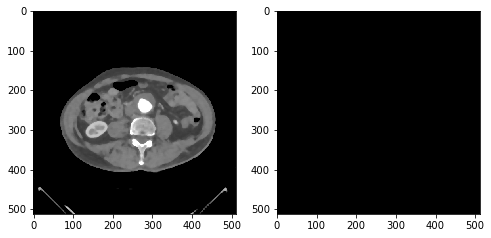

In [13]:
pic = dataset[0]

picture = get_picture(pic)
label = find_contour(picture)